In [1]:
!pip install holidays_ru

In [283]:
import holidays_ru
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE

from catboost import CatBoostRegressor, Pool
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
import lightgbm as lgb
import prophet

import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/views.csv
/kaggle/input/train.csv
/kaggle/input/tvrs_reach.csv
/kaggle/input/test.csv


## Train data reading and features renaming

In [454]:
train = pd.read_csv('/kaggle/input/train.csv', delimiter=';')
train = train.set_axis(['Target', 'Date', 
                        'Break_id', 'Break_start', 'Break_end', 'Break_content', 'Break_distribution',
                        'Programme_name', 'Programme_start', 'Programme_end', 'Programme_category', 
                        'Programme_genre'], axis=1)
train = train.convert_dtypes()
train.head()

,Target,Date,Break_id,Break_start,Break_end,Break_content,Break_distribution,Programme_name,Programme_start,Programme_end,Programme_category,Programme_genre
0,"0,614692654",02.01.2023,4870830561,8:17:33,8:21:40,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
1,"0,869565217",02.01.2023,4870830614,8:34:45,8:38:52,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
2,"0,989505247",02.01.2023,4870830629,8:52:19,8:56:23,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
3,"0,884557721",02.01.2023,4870830684,8:56:31,8:57:28,Announcement,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
4,"0,83958021",02.01.2023,4870830685,9:12:04,9:16:13,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs


## Preprocessing and feature engineering

In [456]:
def time_preproc(df, is_test=False):
    if not is_test:
        train['Target'] = train['Target'].apply(lambda x: float(x.replace(',', '.')))

    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

    df['Break_start_hour'] = df['Break_start'].apply(lambda x: int(x.split(':')[0]))
    df['Break_start_min'] = df['Break_start'].apply(lambda x: int(x.split(':')[1]))
    df['Break_start_sec'] = df['Break_start'].apply(lambda x: int(x.split(':')[2]))
    df['Break_start_abs'] = 60 * df['Break_start_hour'] + df['Break_start_min']

    df['Break_end_hour'] = df['Break_end'].apply(lambda x: int(x.split(':')[0]))
    df['Break_end_min'] = df['Break_end'].apply(lambda x: int(x.split(':')[1]))
    df['Break_end_sec'] = df['Break_end'].apply(lambda x: int(x.split(':')[2]))
    df['Break_end_abs'] = 60 * df['Break_end_hour'] + df['Break_end_min']

    df['Programme_start_hour'] = df['Programme_start'].apply(lambda x: int(x.split(':')[0]))
    df['Programme_start_min'] = df['Programme_start'].apply(lambda x: int(x.split(':')[1]))
    df['Programme_start_sec'] = df['Programme_start'].apply(lambda x: int(x.split(':')[2]))
    df['Programme_start_abs'] = 60 * df['Programme_start_hour'] + df['Programme_start_min']

    df['Programme_end_hour'] = df['Programme_end'].apply(lambda x: int(x.split(':')[0]))
    df['Programme_end_min'] = df['Programme_end'].apply(lambda x: int(x.split(':')[1]))
    df['Programme_end_sec'] = df['Programme_end'].apply(lambda x: int(x.split(':')[2]))
    df['Programme_end_abs'] = 60 * df['Programme_end_hour'] + df['Programme_end_min']

    df = df.drop(columns=['Break_start', 'Break_end', 'Programme_start', 'Programme_end'])
    return df

In [457]:
train = time_preproc(train)

### Basic features

In [458]:
def gen_base_features(df, is_test=False):
    df['Weekday'] = df['Date'].apply(lambda x: x.weekday())
    df['Weekend'] = df['Weekday'] > 4
    df['Holiday'] = df['Date'].apply(lambda x: holidays_ru.check_holiday(x, False))
    df['Pre_holiday'] = df['Date'].apply(lambda x: (not holidays_ru.check_holiday(x, False)) and holidays_ru.check_holiday(x + datetime.timedelta(days=1), False))
    
    df['Break_duration'] = (3600 * df['Break_end_hour'] + 60 * df['Break_end_min'] + df['Break_end_sec']) - \
                          (3600 * df['Break_start_hour'] + 60 * df['Break_start_min'] + df['Break_start_sec'])
                          
    df['Programme_duration'] = (3600 * df['Programme_end_hour'] + 60 * df['Programme_end_min'] + df['Programme_end_sec']) - \
                                  (3600 * df['Programme_start_hour'] + 60 * df['Programme_start_min'] + df['Programme_start_sec'])
    df['From_progamme_start'] = (3600 * df['Break_end_hour'] + 60 * df['Break_end_min'] + df['Break_end_sec']) - \
                                (3600 * df['Programme_start_hour'] + 60 * df['Programme_start_min'] + df['Programme_start_sec'])
    df['Until_progamme_end'] = (3600 * df['Programme_end_hour'] + 60 * df['Programme_end_min'] + df['Programme_end_sec']) - \
                               (3600 * df['Break_start_hour'] + 60 * df['Break_start_min'] + df['Break_start_sec'])
                               
    df['Break_start_of_programme_fraction'] = df['From_progamme_start'] / df['Programme_duration']
    
    df['From_prev_break'] = (3600 * df['Break_start_hour'] + 60 * df['Break_start_min'] + df['Break_start_sec']) - \
                            (3600 * df['Break_end_hour'].shift(1) + 60 * df['Break_end_min'].shift(1) + df['Break_end_sec'].shift(1))
    df.loc[df['From_prev_break'] < 0, 'From_prev_break'] = -100
    
    df['Break_of_programme_fraction'] = df['Break_duration'] / df['Programme_duration']
    return df

In [459]:
train = gen_base_features(train)
train.shape

(30682, 35)

### TV viewing feature

In [460]:
views = pd.read_csv('/kaggle/input/views.csv', delimiter=';')
views = views.replace(np.nan, '0,0')
views['2021'] = views['2021'].apply(lambda x: float(x.replace(',', '.')))
views['2022'] = views['2022'].apply(lambda x: float(x.replace(',', '.')))
views['2023'] = views['2023'].apply(lambda x: float(x.replace(',', '.')))

#Prophet
y = np.hstack([views['2021'].values, views['2022'].values, views['2023'].iloc[:-2].values])
ds = [datetime.date(2021, i, 1) for i in range(1, 13)] + \
     [datetime.date(2022, i, 1) for i in range(1, 13)] + \
     [datetime.date(2023, i, 1) for i in range(1, 11)]
views_prop = pd.DataFrame({'ds': ds,
                           'y': y})
model_prophet = prophet.Prophet(growth='linear', yearly_seasonality=1)
model_prophet.fit(views_prop)
future = model_prophet.make_future_dataframe(periods=1, freq='m')
forecast = model_prophet.predict(future)
views_2023 = views['2023'].iloc[:10].tolist() + [forecast['yhat'].iloc[-1]] 
views_by_month_Prop = {month: views_2023[month-1] for month in range(1,12)}

00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing


### Aggregate statistics by Programme_genre

In [461]:
genre_stats = train.groupby('Programme_genre')['Target'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
genre_stats.rename(columns={
    'mean': 'genre_mean_rating', 
    'std': 'genre_std_rating', 
    'min': 'genre_min_rating', 
    'max': 'genre_max_rating', 
    'median': 'genre_median_rating', 
}, inplace=True)
genre_stats

,Programme_genre,genre_mean_rating,genre_std_rating,genre_min_rating,genre_max_rating,genre_median_rating
0,Educational program,0.507373,0.225188,0.089955,2.788606,0.479760
1,Entertainment programs,1.093739,0.699036,0.000000,4.587706,1.094453
2,Musical programs,0.240270,0.091633,0.044978,0.509745,0.239880
3,News,2.189251,0.782455,0.599700,5.052474,2.098951
4,Social-political programs,0.935144,0.377642,0.089955,3.793103,0.869565


### Aggregate statistics by Programme_category

In [462]:
category_stats = train.groupby('Programme_category')['Target'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
category_stats.rename(columns={
    'mean': 'category_mean_rating', 
    'std': 'category_std_rating', 
    'min': 'category_min_rating', 
    'max': 'category_max_rating', 
    'median': 'category_median_rating', 

}, inplace=True)
category_stats

,Programme_category,category_mean_rating,category_std_rating,category_min_rating,category_max_rating,category_median_rating
0,Comic program,0.985206,0.319753,0.299850,2.293853,0.944528
1,Daily news,2.189251,0.782455,0.599700,5.052474,2.098951
2,Entertainment talk show,0.812077,0.733601,0.000000,2.863568,0.659670
3,Folk music and dances,0.240270,0.091633,0.044978,0.509745,0.239880
4,Geography and countries,0.825791,0.347822,0.224888,2.788606,0.794603
5,Law and justice,1.854707,0.603826,0.569715,3.793103,1.799100
6,"Mixed concert, show, circus performance",1.481145,0.446519,0.569715,3.013493,1.454273
7,Morning airplay,1.112456,0.418890,0.059970,2.278861,1.139430
8,"Program for women, Cookery show",1.045750,0.301341,0.359820,1.829085,1.049475
9,Program on fashion and design,0.782656,0.261707,0.344828,1.754123,0.734633


In [584]:
# Number of ad blocks per program
ad_blocks_per_program = train.groupby('Programme_name')['Break_id'].nunique().reset_index(name='total_ad_blocks_per_program')
# Average duration of ad blocks per program (assuming 'Break_duration' is already calculated in minutes)
avg_ad_duration_per_program = train.groupby('Programme_name')['Break_duration'].mean().reset_index(name='avg_ad_block_duration')
# Average target rating by day of the week
avg_rating_by_day_of_week = train.groupby('Weekday')['Target'].mean().reset_index(name='avg_rating_by_day_of_week')
# timeslot rating
rating_timeslot = train.groupby('Break_start_hour')['Target'].mean().reset_index(name='avg_rating_by_timeslot')

### Merge all features

In [466]:
def gen_more_features(df):
    df['Avg_views'] = df['Date'].apply(lambda x: views_by_month_Prop[x.month])
    df = df.merge(genre_stats, on='Programme_genre', how='left')
    df = df.merge(category_stats, on='Programme_category', how='left')
    df = df.merge(ad_blocks_per_program, on='Programme_name', how='left')
    df = df.merge(avg_ad_duration_per_program, on='Programme_name', how='left')
    df = df.merge(avg_rating_by_day_of_week, on='Weekday', how='left')
    df = df.merge(rating_timeslot, on='Break_start_hour', how='left')
    return df

In [467]:
train = gen_more_features(train)

In [468]:
features_to_drop = ['Break_start_sec', 'Break_end_sec', 
                    'Programme_start_sec', 'Programme_end_sec',
                    'Avg_views', 'Pre_holiday'
                   ]   

def drop_features(df):
    return df.drop(columns=features_to_drop)

train = drop_features(train)

In [470]:
cat_features = list(set(['Break_content', 'Break_distribution', 'Programme_name', 'Programme_category', 
                         'Programme_genre', 'Weekday', 'Weekend', 'Holiday', 'Pre_holiday']) - \
                    set(features_to_drop))

In [471]:
# drop Local break dictribution
train = train.drop(index=train[train['Break_distribution'] == 'Local'].index)
# drop zero Targets
train = train.drop(index=train[train['Target'] == 0].index)

y = train['Target']
X = train.drop(['Target', 'Date', 'Break_id'], axis=1)
X.shape, y.shape

(30571, 44)

In [473]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_idx = train[train['Date'].apply(lambda x: x.month == 10)].index
valid_idx = train[train['Date'].apply(lambda x: x.month < 10)].index
X_train = X.drop(index=train_idx)
y_train = y.drop(index=train_idx)
X_valid = X.drop(index=valid_idx)
y_valid = y.drop(index=valid_idx)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((27332, 41), (27332,), (3239, 41), (3239,))

## CatBoost

In [474]:
scale_target = 1
train_pool = Pool(X_train, label=y_train * scale_target, cat_features=cat_features)
valid_pool = Pool(X_valid, label=y_valid * scale_target, cat_features=cat_features)

ctb_params = dict(iterations=7000,
                   learning_rate=0.007,
                   depth=7,
                   l2_leaf_reg=3,
                   bootstrap_type='Bernoulli',
                   subsample=0.6,
                   colsample_bylevel=0.66,
                   loss_function='MAPE',
                   eval_metric='MAPE',
                   metric_period=100,
                   random_strength=0.69,
#                    task_type='GPU',
#                    devices='0:1',
                   random_state=42,
                   allow_writing_files=False,
                  )
cat_model = CatBoostRegressor(**ctb_params)  # loss_function=MapeObjective(), 
cat_model.fit(train_pool, 
          eval_set=valid_pool,
          early_stopping_rounds=100,
         )

0:	learn: 0.3330438	test: 0.3777747	best: 0.3777747 (0)	total: 30.5ms	remaining: 3m 33s
100:	learn: 0.2193081	test: 0.2453994	best: 0.2453994 (100)	total: 2.79s	remaining: 3m 10s
200:	learn: 0.1771672	test: 0.1866826	best: 0.1866826 (200)	total: 5.44s	remaining: 3m 4s
300:	learn: 0.1616565	test: 0.1608407	best: 0.1608407 (300)	total: 8.06s	remaining: 2m 59s
400:	learn: 0.1540388	test: 0.1468656	best: 0.1468656 (400)	total: 10.7s	remaining: 2m 56s
500:	learn: 0.1498121	test: 0.1392797	best: 0.1392797 (500)	total: 13.4s	remaining: 2m 54s
600:	learn: 0.1471749	test: 0.1348564	best: 0.1348564 (600)	total: 16.1s	remaining: 2m 51s
700:	learn: 0.1450946	test: 0.1315205	best: 0.1315205 (700)	total: 18.8s	remaining: 2m 48s
800:	learn: 0.1434106	test: 0.1291184	best: 0.1291184 (800)	total: 21.9s	remaining: 2m 49s
900:	learn: 0.1417404	test: 0.1270787	best: 0.1270787 (900)	total: 24.6s	remaining: 2m 46s
1000:	learn: 0.1405189	test: 0.1257908	best: 0.1257908 (1000)	total: 27.2s	remaining: 2m 43s
1

In [497]:
preds = cat_model.predict(X_valid)
# Postprocessing
preds = [max(0.015, pred) for pred in preds]
MAPE(y_valid * scale_target, preds)

0.24123751931498752

Text(0.5, 1.0, 'CatBoost top features importance')

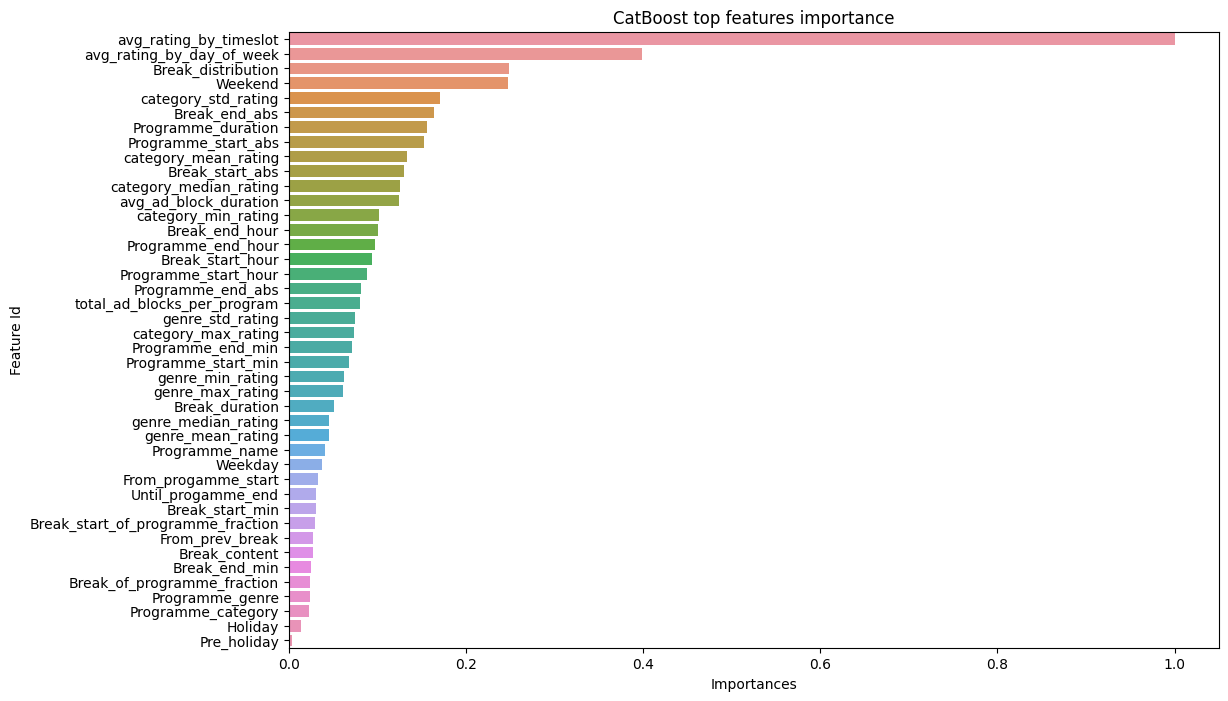

In [442]:
cat_feature_importances = cat_model.get_feature_importance(prettified=True)
cat_feature_importances["Importances"] /= np.max(cat_feature_importances["Importances"])
plt.figure(figsize=(12, 8))
sns.barplot(x="Importances", y="Feature Id", data=cat_feature_importances)
plt.title('CatBoost top features importance')

## LightGBM

In [479]:
X_train[cat_features] = X_train[cat_features].astype('category')
X_valid[cat_features] = X_valid[cat_features].astype('category')

lgb_params = {
        "objective": "mape",
        "n_estimators": 5000,
        "num_leaves": 128,
        "subsample": 0.6,
        "colsample_bytree": 0.66,
        "learning_rate": 0.009,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "boosting": 'gbdt',
        "random_state": 42,
    }

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train,
          y_train,
          eval_set=[(X_valid, y_valid)],
          categorical_feature=cat_features,
          callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
          ], 
         )

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.21912
[200]	valid_0's mape: 0.160074
[300]	valid_0's mape: 0.137554
[400]	valid_0's mape: 0.129705
[500]	valid_0's mape: 0.126806
[600]	valid_0's mape: 0.125619
[700]	valid_0's mape: 0.12496
[800]	valid_0's mape: 0.124551
[900]	valid_0's mape: 0.124301
[1000]	valid_0's mape: 0.123986
[1100]	valid_0's mape: 0.123884
[1200]	valid_0's mape: 0.123767
[1300]	valid_0's mape: 0.12373
[1400]	valid_0's mape: 0.123716
[1500]	valid_0's mape: 0.123686
[1600]	valid_0's mape: 0.123691
[1700]	valid_0's mape: 0.123664
[1800]	valid_0's mape: 0.123598
[1900]	valid_0's mape: 0.123581
[2000]	valid_0's mape: 0.123562
[2100]	valid_0's mape: 0.123528
[2200]	valid_0's mape: 0.123516
[2300]	valid_0's mape: 0.123517
[2400]	valid_0's mape: 0.123478
[2500]	valid_0's mape: 0.123473
[2600]	valid_0's mape: 0.12346
[2700]	vali

LGBMRegressor(boosting='gbdt', colsample_bytree=0.66, importance_type='gain',
              learning_rate=0.009, n_estimators=5000, n_jobs=4, num_leaves=128,
              objective='mape', random_state=42, subsample=0.6, verbosity=-1)

In [490]:
preds = lgb_model.predict(X_valid)
preds = [max(0.03, pred) for pred in preds]
MAPE(y_valid, preds)

0.23198094151634382

Text(0.5, 1.0, 'LightGBM top features importance')

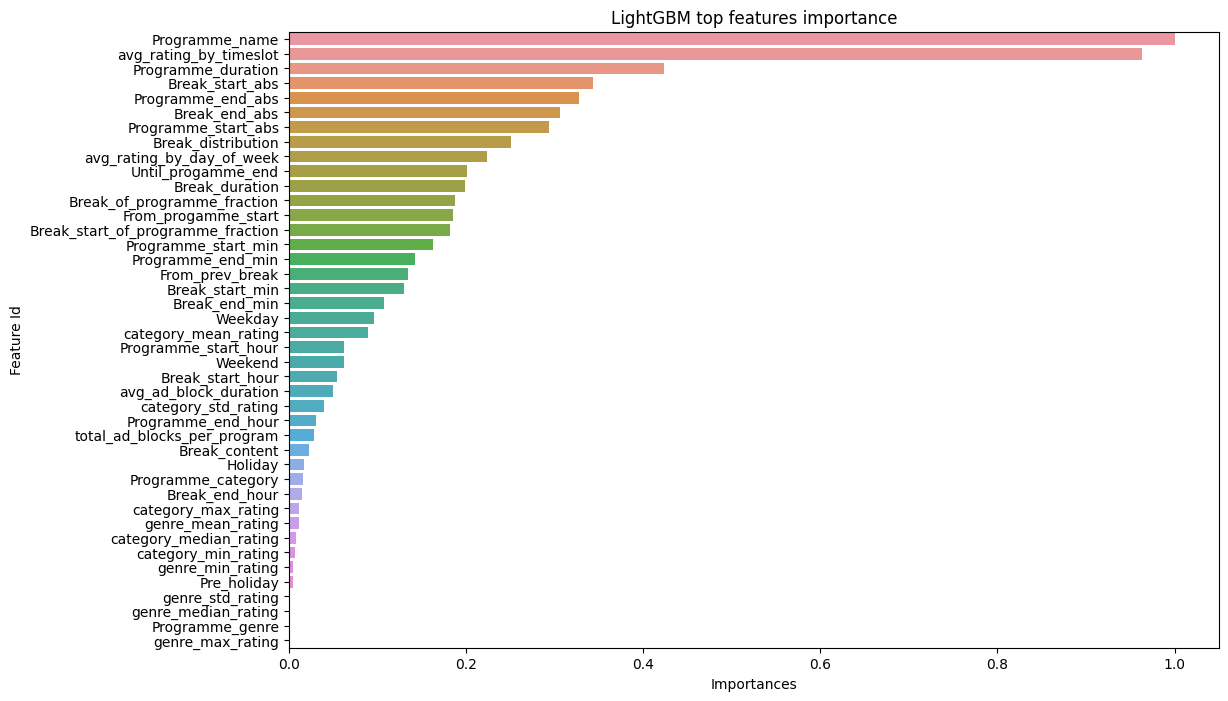

In [436]:
fea_imp = pd.DataFrame({'Feature Id':X_train.columns, 'Importances':lgb_model.feature_importances_})
lgbm_feature_importances = fea_imp.loc[fea_imp['Importances'] > 0].sort_values(by=['Importances'], ascending = False)
lgbm_feature_importances['Importances'] /= np.max(lgbm_feature_importances['Importances'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Importances", y="Feature Id", data=lgbm_feature_importances)
plt.title('LightGBM top features importance')

### Mean importances of features 

Text(0.5, 1.0, 'Mean features importance')

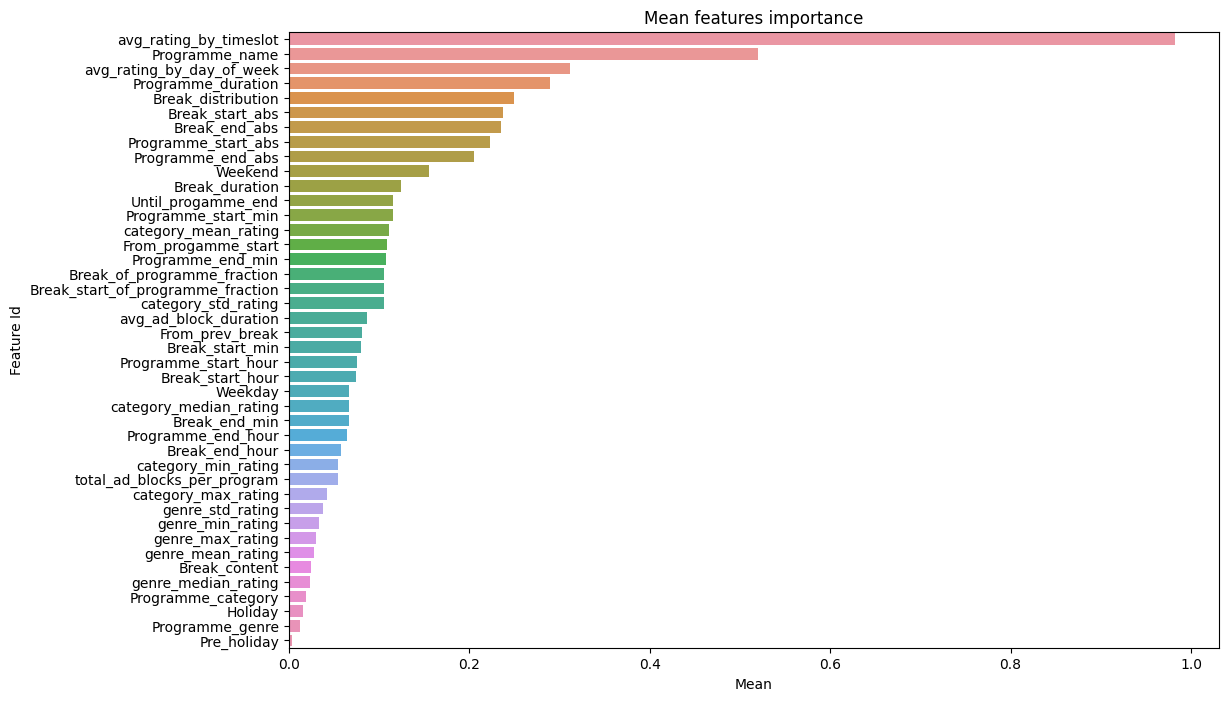

In [451]:
feature_importances = lgbm_feature_importances.merge(cat_feature_importances, on='Feature Id')
feature_importances = feature_importances.rename(columns={'Importances_y':'CatBoost', 'Importances_x':'LightGBM'})
feature_importances['Mean'] = (feature_importances['CatBoost'] + feature_importances['LightGBM'])/2
feature_importances = feature_importances.sort_values(by=['Mean'], ascending = False)
feature_importances.to_csv('feature_importances.csv')
plt.figure(figsize=(12, 8))
sns.barplot(x="Mean", y="Feature Id", data=feature_importances)
plt.title('Mean features importance')

## LightGBM + CatBoost ensemble

In [517]:
cat_preds = cat_model.predict(X_valid)
cat_preds = np.array([max(0.01499, pred) for pred in cat_preds])
print(f"CatBoost valid MAPE = {MAPE(y_valid, cat_preds)}")

lgbm_preds = lgb_model.predict(X_valid)
lgbm_preds = np.array([max(0.03, pred) for pred in lgbm_preds])
print(f"LightGBM valid MAPE = {MAPE(y_valid, lgbm_preds)}")

meta_preds = 0.2 * cat_preds + 0.8 * lgbm_preds
print(f"Metamodel valid MAPE = {MAPE(y_valid, meta_preds)}")
valid_meta_preds = meta_preds

CatBoost valid MAPE = 0.2412375881223187
LightGBM valid MAPE = 0.23198094151634382
Metamodel valid MAPE = 0.231634389064325


### MAPE on train data

In [536]:
cat_preds = cat_model.predict(X_train)
cat_preds = np.array([max(0.01499, pred) for pred in cat_preds])
print(f"CatBoost train MAPE = {MAPE(y_train, cat_preds)}")

lgbm_preds = lgb_model.predict(X_train)
lgbm_preds = np.array([max(0.03, pred) for pred in lgbm_preds])
print(f"LightGBM train MAPE = {MAPE(y_train, lgbm_preds)}")

meta_preds = 0.2 * cat_preds + 0.8 * lgbm_preds
print(f"Metamodel train MAPE = {MAPE(y_train, meta_preds)}")
train_meta_preds_df = pd.DataFrame({'real':y_train, 'preds':meta_preds}, index=y_train.index)

CatBoost train MAPE = 0.20684600636249317
LightGBM train MAPE = 0.14892452319461139
Metamodel train MAPE = 0.15952206727578508


In [547]:
scores = []
names = []
for group in X_train.groupby('Programme_name'):
    names.append(group[0])
    group_df = group[1]
    scores.append(MAPE(train_meta_preds_df.loc[group_df.index, 'real'], 
                     train_meta_preds_df.loc[group_df.index, 'preds']))
df_train_score = pd.DataFrame({'name':names, 'MAPE':scores})
df_train_score = df_train_score.sort_values(by='name')
df_train_score.to_excel('train_score.xlsx')

## 5-fold CV for metamodel

In [567]:
X[cat_features] = X[cat_features].astype('category')

folds_idx = []
folds_idx.append(train[train['Date'].apply(lambda x: x.month <= 2)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 2 and x.month <= 4)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 4 and x.month <= 6)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 6 and x.month <= 8)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 8 and x.month <= 10)].index)
lgb_models = []
cat_models = []
scores = []
for fold in range(5):
    print(f'{fold=}')
    valid_idx = np.array(folds_idx[fold])
    train_idx = np.hstack(folds_idx[:fold] + folds_idx[fold+1:])
    X_fold_train = X.drop(index=valid_idx)
    y_fold_train = y.drop(index=valid_idx)
    X_fold_valid = X.drop(index=train_idx)
    y_fold_valid = y.drop(index=train_idx)
    train_pool = Pool(X_fold_train, label=y_fold_train, cat_features=cat_features)
    valid_pool = Pool(X_fold_valid, label=y_fold_valid, cat_features=cat_features)


    lgb_params = {
            "objective": "mape",
            "n_estimators": 5000,
            "num_leaves": 128,#256,
            "subsample": 0.6,
            "colsample_bytree": 0.66,
            "learning_rate": 0.009,
            "n_jobs": 4,
            "verbosity": -1,
            "importance_type": "gain",
            "boosting": 'gbdt',
            "random_state": 42,
        }

    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(X_fold_train,
                  y_fold_train,
                  eval_set=[(X_fold_valid, y_fold_valid)],
                  categorical_feature=cat_features,
                  callbacks=[
                    lgb.callback.early_stopping(stopping_rounds=100),
                    lgb.callback.log_evaluation(period=100),
                  ], 
                 )
    lgb_models.append(lgb_model)
    
    score = MAPE(y_fold_valid, lgb_model.predict(X_fold_valid))
    print(f"fold lgb MAPE = {score}")    
    
    ctb_params = dict(iterations=5000,
                       learning_rate=0.007,
                       depth=7,
                       l2_leaf_reg=3,
                       bootstrap_type='Bernoulli',
                       subsample=0.6,
                       colsample_bylevel=0.66,
                       loss_function='MAPE',
                       eval_metric='MAPE',
                       metric_period=100,
                       random_strength=0.69,
                       random_state=42,
                       allow_writing_files=False,
                      )
    cat_model = CatBoostRegressor(**ctb_params)
    cat_model.fit(train_pool, 
              eval_set=valid_pool,
              early_stopping_rounds=100,
             )
    cat_models.append(cat_model)
    
    score = MAPE(y_fold_valid, cat_model.predict(X_fold_valid))
    print(f"fold cat MAPE = {score}")    

fold=0
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.227543
[200]	valid_0's mape: 0.186633
[300]	valid_0's mape: 0.17422
[400]	valid_0's mape: 0.170337
[500]	valid_0's mape: 0.168994
[600]	valid_0's mape: 0.168237
[700]	valid_0's mape: 0.168046
[800]	valid_0's mape: 0.167868
[900]	valid_0's mape: 0.167809
[1000]	valid_0's mape: 0.167769
[1100]	valid_0's mape: 0.167759
[1200]	valid_0's mape: 0.167728
[1300]	valid_0's mape: 0.167667
[1400]	valid_0's mape: 0.167422
[1500]	valid_0's mape: 0.167342
Early stopping, best iteration is:
[1461]	valid_0's mape: 0.167303
fold lgb MAPE = 0.24445085697597238
0:	learn: 0.3354193	test: 0.3507211	best: 0.3507211 (0)	total: 27.9ms	remaining: 2m 19s


100:	learn: 0.2159284	test: 0.2453429	best: 0.2453429 (100)	total: 2.76s	remaining: 2m 13s
200:	learn: 0.1721175	test: 0.2041042	best: 0.2041042 (200)	total: 5.41s	remaining: 2m 9s
300:	learn: 0.1557912	test: 0.1877304	best: 0.1877304 (300)	total: 8s	remaining: 2m 4s
400:	learn: 0.1484144	test: 0.1804072	best: 0.1804072 (400)	total: 10.7s	remaining: 2m 2s
500:	learn: 0.1440724	test: 0.1762523	best: 0.1762523 (500)	total: 13.7s	remaining: 2m 2s
600:	learn: 0.1412467	test: 0.1737152	best: 0.1737152 (600)	total: 16.3s	remaining: 1m 59s
700:	learn: 0.1389133	test: 0.1720627	best: 0.1720627 (700)	total: 19s	remaining: 1m 56s
800:	learn: 0.1368275	test: 0.1705129	best: 0.1705129 (800)	total: 21.7s	remaining: 1m 53s
900:	learn: 0.1353479	test: 0.1696474	best: 0.1696474 (900)	total: 24.3s	remaining: 1m 50s
1000:	learn: 0.1342403	test: 0.1688796	best: 0.1688796 (1000)	total: 27s	remaining: 1m 47s
1100:	learn: 0.1332839	test: 0.1682420	best: 0.1682420 (1100)	total: 29.7s	remaining: 1m 45s
1200:	

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.204758
[200]	valid_0's mape: 0.159439
[300]	valid_0's mape: 0.145465
[400]	valid_0's mape: 0.141238
[500]	valid_0's mape: 0.139585
[600]	valid_0's mape: 0.138964
[700]	valid_0's mape: 0.138629
[800]	valid_0's mape: 0.1383
[900]	valid_0's mape: 0.138072
[1000]	valid_0's mape: 0.137954
[1100]	valid_0's mape: 0.137876
[1200]	valid_0's mape: 0.137836
[1300]	valid_0's mape: 0.137833
Early stopping, best iteration is:
[1289]	valid_0's mape: 0.137818
fold lgb MAPE = 0.20955843479964797
0:	learn: 0.3359314	test: 0.3455762	best: 0.3455762 (0)	total: 25ms	remaining: 2m 4s


100:	learn: 0.2210954	test: 0.2222894	best: 0.2222894 (100)	total: 2.75s	remaining: 2m 13s
200:	learn: 0.1782746	test: 0.1737064	best: 0.1737064 (200)	total: 5.47s	remaining: 2m 10s
300:	learn: 0.1622670	test: 0.1548504	best: 0.1548504 (300)	total: 8.05s	remaining: 2m 5s
400:	learn: 0.1545839	test: 0.1460365	best: 0.1460365 (400)	total: 10.6s	remaining: 2m 1s
500:	learn: 0.1502611	test: 0.1411913	best: 0.1411913 (500)	total: 13.2s	remaining: 1m 58s
600:	learn: 0.1474329	test: 0.1384171	best: 0.1384171 (600)	total: 15.7s	remaining: 1m 54s
700:	learn: 0.1453117	test: 0.1365904	best: 0.1365904 (700)	total: 18.3s	remaining: 1m 52s
800:	learn: 0.1433877	test: 0.1350785	best: 0.1350785 (800)	total: 20.9s	remaining: 1m 49s
900:	learn: 0.1417892	test: 0.1337723	best: 0.1337723 (900)	total: 23.5s	remaining: 1m 46s
1000:	learn: 0.1406095	test: 0.1329370	best: 0.1329370 (1000)	total: 26.1s	remaining: 1m 44s
1100:	learn: 0.1396123	test: 0.1322254	best: 0.1322184 (1099)	total: 28.9s	remaining: 1m 4

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.193457
[200]	valid_0's mape: 0.151922
[300]	valid_0's mape: 0.140046
[400]	valid_0's mape: 0.137019
[500]	valid_0's mape: 0.136453
[600]	valid_0's mape: 0.136386
Early stopping, best iteration is:
[578]	valid_0's mape: 0.136325
fold lgb MAPE = 0.2241678066957942
0:	learn: 0.3386076	test: 0.3343251	best: 0.3343251 (0)	total: 30.8ms	remaining: 2m 33s


100:	learn: 0.2227159	test: 0.2142628	best: 0.2142628 (100)	total: 2.64s	remaining: 2m 8s
200:	learn: 0.1796671	test: 0.1721218	best: 0.1721218 (200)	total: 5.2s	remaining: 2m 4s
300:	learn: 0.1633078	test: 0.1566888	best: 0.1566888 (300)	total: 7.76s	remaining: 2m 1s
400:	learn: 0.1549173	test: 0.1493988	best: 0.1493988 (400)	total: 10.3s	remaining: 1m 57s
500:	learn: 0.1504321	test: 0.1461552	best: 0.1461552 (500)	total: 12.8s	remaining: 1m 54s
600:	learn: 0.1473401	test: 0.1444867	best: 0.1444867 (600)	total: 15.3s	remaining: 1m 52s
700:	learn: 0.1450952	test: 0.1435602	best: 0.1435602 (700)	total: 17.9s	remaining: 1m 49s
800:	learn: 0.1429065	test: 0.1428480	best: 0.1428393 (799)	total: 20.3s	remaining: 1m 46s
900:	learn: 0.1412506	test: 0.1424528	best: 0.1424429 (898)	total: 22.8s	remaining: 1m 43s
1000:	learn: 0.1399159	test: 0.1423131	best: 0.1423108 (999)	total: 25.3s	remaining: 1m 40s
1100:	learn: 0.1387491	test: 0.1422517	best: 0.1422364 (1077)	total: 28.3s	remaining: 1m 40s


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.188174
[200]	valid_0's mape: 0.173717
[300]	valid_0's mape: 0.172142
Early stopping, best iteration is:
[292]	valid_0's mape: 0.172091
fold lgb MAPE = 0.3340897793508754
0:	learn: 0.3492700	test: 0.2938845	best: 0.2938845 (0)	total: 55.2ms	remaining: 4m 35s


100:	learn: 0.2241702	test: 0.2039125	best: 0.2039125 (100)	total: 2.94s	remaining: 2m 22s
200:	learn: 0.1753685	test: 0.1844713	best: 0.1844713 (200)	total: 5.46s	remaining: 2m 10s
300:	learn: 0.1568129	test: 0.1822099	best: 0.1820892 (287)	total: 7.97s	remaining: 2m 4s
400:	learn: 0.1475993	test: 0.1818318	best: 0.1818303 (348)	total: 10.5s	remaining: 1m 59s
500:	learn: 0.1428618	test: 0.1818174	best: 0.1816802 (473)	total: 12.9s	remaining: 1m 55s
600:	learn: 0.1398379	test: 0.1814169	best: 0.1814159 (598)	total: 15.5s	remaining: 1m 53s
700:	learn: 0.1376797	test: 0.1811621	best: 0.1811320 (684)	total: 18s	remaining: 1m 50s
800:	learn: 0.1353750	test: 0.1804320	best: 0.1804297 (799)	total: 20.5s	remaining: 1m 47s
900:	learn: 0.1337058	test: 0.1799297	best: 0.1799297 (900)	total: 23s	remaining: 1m 44s
1000:	learn: 0.1322757	test: 0.1795995	best: 0.1795995 (1000)	total: 25.7s	remaining: 1m 42s
1100:	learn: 0.1311331	test: 0.1795346	best: 0.1795253 (1013)	total: 28.3s	remaining: 1m 40s


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Break_content', 'Break_distribution', 'Holiday', 'Programme_category', 'Programme_genre', 'Programme_name', 'Weekday', 'Weekend']



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.224171
[200]	valid_0's mape: 0.172942
[300]	valid_0's mape: 0.154603
[400]	valid_0's mape: 0.149329
[500]	valid_0's mape: 0.147755
[600]	valid_0's mape: 0.146997
[700]	valid_0's mape: 0.146938
[800]	valid_0's mape: 0.146725
[900]	valid_0's mape: 0.146713
Early stopping, best iteration is:
[829]	valid_0's mape: 0.146665
fold lgb MAPE = 0.2796750402696848
0:	learn: 0.3290986	test: 0.3714086	best: 0.3714086 (0)	total: 38.1ms	remaining: 3m 10s


100:	learn: 0.2169241	test: 0.2487132	best: 0.2487132 (100)	total: 2.9s	remaining: 2m 20s
200:	learn: 0.1759864	test: 0.1976298	best: 0.1976298 (200)	total: 5.45s	remaining: 2m 10s
300:	learn: 0.1612439	test: 0.1774091	best: 0.1774091 (300)	total: 7.94s	remaining: 2m 3s
400:	learn: 0.1537941	test: 0.1660568	best: 0.1660568 (400)	total: 10.5s	remaining: 2m
500:	learn: 0.1495965	test: 0.1594898	best: 0.1594898 (500)	total: 13.1s	remaining: 1m 57s
600:	learn: 0.1468890	test: 0.1559081	best: 0.1559081 (600)	total: 15.7s	remaining: 1m 54s
700:	learn: 0.1448950	test: 0.1536615	best: 0.1536615 (700)	total: 18.2s	remaining: 1m 51s
800:	learn: 0.1430117	test: 0.1520343	best: 0.1520343 (800)	total: 20.7s	remaining: 1m 48s
900:	learn: 0.1415136	test: 0.1511406	best: 0.1511406 (900)	total: 23.3s	remaining: 1m 46s
1000:	learn: 0.1402836	test: 0.1500862	best: 0.1500836 (999)	total: 25.8s	remaining: 1m 43s
1100:	learn: 0.1392871	test: 0.1495549	best: 0.1495281 (1090)	total: 28.3s	remaining: 1m 40s
12

In [568]:
cv_meta_preds_dfs = []
for fold in range(5):
    cat_model = cat_models[fold]    
    lgb_model = lgb_models[fold]
    
    train_idx = np.hstack(folds_idx[:fold] + folds_idx[fold+1:])
    X_fold_valid = X.drop(index=train_idx)
    y_fold_valid = y.drop(index=train_idx)
    
    cat_preds = cat_model.predict(X_fold_valid)
    cat_preds = np.array([max(0.01499, pred) for pred in cat_preds])
    print(f"CatBoost train MAPE = {MAPE(y_fold_valid, cat_preds)}")

    lgbm_preds = lgb_model.predict(X_fold_valid)
    lgbm_preds = np.array([max(0.03, pred) for pred in lgbm_preds])
    print(f"LightGBM train MAPE = {MAPE(y_fold_valid, lgbm_preds)}")

    meta_preds = 0.2 * cat_preds + 0.8 * lgbm_preds
    print(f"Metamodel train MAPE = {MAPE(y_fold_valid, meta_preds)}")
    cv_meta_preds_dfs.append(pd.DataFrame({'real':y_fold_valid, 'preds':meta_preds}, index=y_fold_valid.index))

CatBoost train MAPE = 0.2434737026809059
LightGBM train MAPE = 0.24431265493201368
Metamodel train MAPE = 0.24309855303426903
CatBoost train MAPE = 0.20346883446197922
LightGBM train MAPE = 0.2094357619162556
Metamodel train MAPE = 0.2069210411666523
CatBoost train MAPE = 0.22710940998520832
LightGBM train MAPE = 0.22417257974119584
Metamodel train MAPE = 0.22299953524788416
CatBoost train MAPE = 0.2833973857594687
LightGBM train MAPE = 0.3340897793508754
Metamodel train MAPE = 0.3216092037273922
CatBoost train MAPE = 0.28250052443070556
LightGBM train MAPE = 0.2798533072297213
Metamodel train MAPE = 0.2782367894622968


In [573]:
MAPE(cv_meta_preds_df['real'], cv_meta_preds_df['preds'])

0.25530214165282317

In [574]:
cv_meta_preds_df = pd.concat(cv_meta_preds_dfs)
scores = []
names = []
for group in X.groupby('Programme_name'):
    names.append(group[0])
    group_df = group[1]
    scores.append(MAPE(cv_meta_preds_df.loc[group_df.index, 'real'], 
                       cv_meta_preds_df.loc[group_df.index, 'preds']))
df_cv_score = pd.DataFrame({'name':names, 'MAPE':scores})
df_cv_score = df_cv_score.sort_values(by='name')
df_cv_score.to_excel('cv_score.xlsx')

## Train on the whole train data

In [575]:
full_train_pool = Pool(X, label=y, cat_features=cat_features)

ctb_params = dict(iterations=3500,
                   learning_rate=0.007,
                   depth=7,
                   l2_leaf_reg=3,
                   bootstrap_type='Bernoulli',
                   subsample=0.6,
                   colsample_bylevel=0.66,
                   loss_function='MAPE',
                   eval_metric='MAPE',
                   metric_period=100,
                   random_strength=0.69,
                   random_state=42,
                   allow_writing_files=False,
                  )

cat_model = CatBoostRegressor(**ctb_params)
cat_model.fit(full_train_pool)

0:	learn: 0.3376948	total: 40.7ms	remaining: 2m 22s
100:	learn: 0.2203862	total: 2.96s	remaining: 1m 39s
200:	learn: 0.1772017	total: 5.83s	remaining: 1m 35s
300:	learn: 0.1609235	total: 8.68s	remaining: 1m 32s
400:	learn: 0.1527294	total: 11.5s	remaining: 1m 29s
500:	learn: 0.1483417	total: 14.4s	remaining: 1m 26s
600:	learn: 0.1454726	total: 17.3s	remaining: 1m 23s
700:	learn: 0.1431615	total: 20.1s	remaining: 1m 20s
800:	learn: 0.1414557	total: 22.9s	remaining: 1m 17s
900:	learn: 0.1400747	total: 25.6s	remaining: 1m 13s
1000:	learn: 0.1389024	total: 28.4s	remaining: 1m 10s
1100:	learn: 0.1379103	total: 31.5s	remaining: 1m 8s
1200:	learn: 0.1371674	total: 34.4s	remaining: 1m 5s
1300:	learn: 0.1364173	total: 37.3s	remaining: 1m 2s
1400:	learn: 0.1356844	total: 40.1s	remaining: 1m
1500:	learn: 0.1349135	total: 43.1s	remaining: 57.3s
1600:	learn: 0.1341031	total: 46s	remaining: 54.6s
1700:	learn: 0.1333798	total: 48.9s	remaining: 51.7s
1800:	learn: 0.1326935	total: 51.9s	remaining: 48.9

In [576]:
X[cat_features] = X[cat_features].astype('category')

lgb_params = {
        "objective": "mape",
        "n_estimators": 3200,
        "num_leaves": 128,
        "subsample": 0.6,
        "colsample_bytree": 0.66,
        "learning_rate": 0.009,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "boosting": 'gbdt',
        "random_state": 42,
    }

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X, y, categorical_feature=cat_features)

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', colsample_bytree=0.66, importance_type='gain',
              learning_rate=0.009, n_estimators=3200, n_jobs=4, num_leaves=128,
              objective='mape', random_state=42, subsample=0.6, verbosity=-1)

## Test data read and prediction

In [ ]:
test = pd.read_csv('/kaggle/input/test.csv', delimiter=';')

test = test.set_axis(['Date', 'Break_id', 'Break_start', 'Break_end', 'Break_content', 'Break_distribution',
                      'Programme_name', 'Programme_start', 'Programme_end', 'Programme_category', 'Programme_genre', 'Target'], axis=1)
test = test.convert_dtypes()

In [ ]:
X_test = time_preproc(test, is_test=True)
X_test = gen_base_features(X_test)
X_test = gen_more_features(X_test)
X_test = drop_features(X_test)
X_test = X_test.drop(['Target', 'Date', 'Break_id'], axis=1)
X_test[cat_features] = X_test[cat_features].astype('category')

In [583]:
cat_preds = cat_model.predict(X_test)
cat_preds = np.array([max(0.01499, pred) for pred in cat_preds])

lgbm_preds = lgb_model.predict(X_test)
lgbm_preds = np.array([max(0.03, pred) for pred in lgbm_preds])

test_meta_preds = 0.2 * cat_preds + 0.8 * lgbm_preds
pd.Series(test_meta_preds).to_excel('test_preds.xlsx')